#  PMLMDM Final Project: The Causal Effects of Economic Development on Human Rights, Democracy and the Rule of Law 
__Mehmet Atakan Çavuşlu - MMA191<br>
Tor Anders Høksås - MMA191__
***

# Introduction

It is a long popular debate whether economic development and human righs, democracy are tied, and is there any causality between these elements in a country-level. We see that often times economically high-performing countries also have more freedom and the human rights are considered to be very importing aspect in the policies of aforementioned countries. There are also some counter-arguements about the same issue. 

In fact, it became a chicken and an egg problem, often times having no real answer whether economic development brings democracy and human rights, or vice versa: being democratic and putting importance on human rights brings wealth and economic development.

This research aims to get statistical insighths about the relationship between economic development and the status of democracy for a country.

***

### HYPOTHESIS
__H1:__ There is a significant correlation between economic development and the status
of human rights, democracy, press freedom and the rule of law for a country<br>
__H0:__ There is not a significant correlation between economic development and the status of human rights, democracy, press freedom and the rule of law for a country

__We try to come up with working ML models that relates to the hypothesis with satisfactory success__

In [35]:
# Import basic statistical and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wbdata
import datetime
from sklearn import linear_model
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Data Collection
To use in the research, following data are collected to be able to assess _Democracy, Human Rights and The Rule of Law_ in a country (mentioned thereafter as _human data_):

- __Democracy Index 2018, The Economist Intelligence Unit__<br>
https://www.eiu.com/topic/democracy-index<br>
Index based on _Electoral Process and Pluralism, Functioning of Government, Political Participation, Political Culture, Civil Liberties_
- __World Press Freedom Index 2019, Reporters Without Borders__<br>
https://rsf.org/en/ranking<br>
Index based on _Pluralism, Media Independence, Environment and Self-censorship, Legislative Framework, Transparency, Infrastructure, Abuses_
- __Human Rights Index 2014, Our World In Data University of Oxford__<br>
https://ourworldindata.org/human-rights<br>
Index based on _Human Rights Protection from Political Oppression, Human Rights Violations_
- __Rule of Law Index 2019, World Justice Project__<br>
https://worldjusticeproject.org/our- work/research-and-data/wjp-rule-law-index-2019<br>
Index based on _Accountability, Just Laws, Open Government, Accessible & Impartial Dispute Resolution_

The data about economic development is collected from WorldBank API (https://data.worldbank.org) containing the following indicatiors (mentioned thereafter as _economic data_):

- __'NY.GDP.PCAP.CD':__ 'GDP per capita'
- __'PA.NUS.PPP':__ 'PPP conversion factor'
- __'FP.CPI.TOTL.ZG':__ 'Inflation'
- __'SL.UEM.TOTL.ZS':__ 'Unemployment (%)'
- __'SP.RUR.TOTL.ZS':__ 'Rural Population (%)'
- __'SL.TLF.CACT.NE.ZS':__ 'Labor force participation rate (%)'

Variables such as GNI Per Capita, GDP per capita adjusted for PPP, GDP per person employed are not needed and discarded due to high multicollinearity with above variables.
***
### Collection of Human Data

In [2]:
# Read Rule of law index data from World Justice Project
wjp_data = pd.read_excel('wjp_rule_of_law_index.xlsx', sheet_name='WJP ROL Index 2019 Scores')
wjp_data = wjp_data[wjp_data['Country'] == 'WJP Rule of Law Index: Overall Score'].transpose()
wjp_data.columns = wjp_data.iloc[0]
wjp_data.reset_index(inplace=True)
wjp_data = wjp_data.reindex(wjp_data.index.drop(0))
wjp_data.reset_index(inplace=True)
wjp_data.drop(['level_0'], axis=1, inplace=True)
wjp_data.columns = ['Country', 'Overall Rule of Law Index']
wjp_data.set_index('Country', inplace=True)
wjp_data.head()

,Overall Rule of Law Index
Country,
Afghanistan,0.34764
Albania,0.506076
Algeria,0.505867
Angola,0.41263
Antigua and Barbuda,0.627957


In [3]:
# Read Press Freedom index data from Reporters Without Borders
press_freedom_data = pd.read_csv('press_freedom.csv', decimal=",")
press_freedom_data = press_freedom_data[["EN_country","Score 2019"]]
press_freedom_data.columns = ['Country', 'Press Freedom Score']
press_freedom_data.set_index('Country', inplace=True)
press_freedom_data.head()

,Press Freedom Score
Country,
Norway,7.82
Finland,7.90
Sweden,8.31
Netherlands,8.63
Denmark,9.87


In [4]:
# Read Human Rights Protection index data from Our World in Data, provided by Oxford University
human_rights_data = pd.read_csv('human_rights_protection.csv')
human_rights_data = human_rights_data[human_rights_data['Year'] == 2014]
human_rights_data = human_rights_data[["Entity","Human Rights Protection Scores – by Christopher Farris and Keith Schnakenberg"]]
human_rights_data.reset_index(inplace=True)
human_rights_data.drop(['index'], axis=1, inplace=True)
human_rights_data.columns = ['Country', 'Human Rights Protection Score']
human_rights_data.set_index('Country', inplace=True)
human_rights_data.head()

,Human Rights Protection Score
Country,
Afghanistan,-1.281600
Albania,0.365031
Algeria,0.015590
Andorra,3.265850
Angola,-0.603419


In [5]:
# Read Human Rights Violations index data from Our World in Data, provided by Oxford University
human_rights_violation = pd.read_csv('human_rights_violations.csv')
human_rights_violation = human_rights_violation[human_rights_violation['Year'] == 2014]
human_rights_violation = human_rights_violation[['Entity', 'Unnamed: 3']]
human_rights_violation.reset_index(inplace=True)
human_rights_violation.drop(['index'], axis=1, inplace=True)
human_rights_violation.columns = ['Country', 'Human Rights Violations']
human_rights_violation.set_index('Country', inplace=True)
human_rights_violation.head()

,Human Rights Violations
Country,
Afghanistan,8.3
Albania,5.5
Algeria,7.4
Angola,7.0
Antigua and Barbuda,4.7


In [6]:
# Read Democracy index data from The Economist Intelligence Unit
democracy_data = pd.read_excel('democracy_index.xlsx')
democracy_data = democracy_data[['Countries','Overall score ']]
democracy_data.reset_index(inplace=True)
democracy_data.dropna(inplace=True)
democracy_data.drop(['index'], axis=1, inplace=True)
democracy_data.columns = ['Country', 'Democracy Index']
democracy_data.set_index('Country', inplace=True)
democracy_data.head()

,Democracy Index
Country,
Afghanistan,2.97
Albania,5.98
Algeria,3.50
Angola,3.62
Argentina,7.02


After reading all the indexes to assess _Democracy, Human Rights and The Rule of Law_ in a country-level, a new dataframe with all these indices called __human_data__ is created.

In [7]:
human_data = pd.concat([wjp_data, press_freedom_data, human_rights_data, human_rights_violation, democracy_data], axis=1, sort=True)
human_data['Overall Rule of Law Index'] = pd.to_numeric(human_data['Overall Rule of Law Index'])
human_data.head()

,Overall Rule of Law Index,Press Freedom Score,Human Rights Protection Score,Human Rights Violations,Democracy Index
Afghanistan,0.347640,36.55,-1.281600,8.3,2.97
Albania,0.506076,29.84,0.365031,5.5,5.98
Algeria,0.505867,45.75,0.015590,7.4,3.50
Andorra,NaN,24.63,3.265850,NaN,NaN
Angola,0.412630,34.96,-0.603419,7.0,3.62


### EDA and Data Preprocessing on Human Data

In [8]:
# Data count for each column
human_data.count()

Overall Rule of Law Index        126
Press Freedom Score              180
Human Rights Protection Score    196
Human Rights Violations          179
Democracy Index                  167
dtype: int64

In [9]:
# Total Missing data per column
human_data.isnull().sum()

Overall Rule of Law Index        151
Press Freedom Score               97
Human Rights Protection Score     81
Human Rights Violations           98
Democracy Index                  110
dtype: int64

#### Handling Missing Data on Human Data
There is lots of missing data for a lot of countries in the table. Omitting NaN values would significantly limit the model implications since it leaves such a small amount of data available.

Popular and easier Data Imputation methods such as mean/median would not work in our case, because a lot of the data missing are from edge countries, which means values of not around average but rather on the edges of the scale.

To overcome this issue, an imputing method of __KNN Imptuting__ is used. The detailed explanation of such method gathered from scikitlearn docs is:

_Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close. By default, a euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors._

This would prove useful since it is expected that countries with other given variables similar should perform similarly in the NaN values. 

To make the imputations better, before KNN imputing, the rows with more than 2 NaN values can be omitted. Since having so much NaNs simply make it hard to make imputations about that country.

In [10]:
# Omitting rows with more than 2 NaN values
human_data_omitted = human_data.dropna(thresh=2)

In [11]:
# Impute NaN with KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
human_data_filled_array = imputer.fit_transform(human_data_omitted)
human_data_filled = pd.DataFrame(human_data_filled_array)
human_data_filled.columns = ['Overall Rule of Law Index', 'Press Freedom Score', 'Human Rights Protection Score', 'Human Rights Violations', 'Democracy Index']
human_data_filled.index = human_data_omitted.index
human_data_filled.isnull().sum()

Overall Rule of Law Index        0
Press Freedom Score              0
Human Rights Protection Score    0
Human Rights Violations          0
Democracy Index                  0
dtype: int64

In [12]:
human_data_filled.count()

Overall Rule of Law Index        186
Press Freedom Score              186
Human Rights Protection Score    186
Human Rights Violations          186
Democracy Index                  186
dtype: int64

In [13]:
human_data_filled.corr()

,Overall Rule of Law Index,Press Freedom Score,Human Rights Protection Score,Human Rights Violations,Democracy Index
Overall Rule of Law Index,1.000000,-0.613701,0.784069,-0.832201,0.635293
Press Freedom Score,-0.613701,1.000000,-0.669364,0.760259,-0.710291
Human Rights Protection Score,0.784069,-0.669364,1.000000,-0.792795,0.589848
Human Rights Violations,-0.832201,0.760259,-0.792795,1.000000,-0.802528
Democracy Index,0.635293,-0.710291,0.589848,-0.802528,1.000000


In [14]:
human_data_omitted.corr()

,Overall Rule of Law Index,Press Freedom Score,Human Rights Protection Score,Human Rights Violations,Democracy Index
Overall Rule of Law Index,1.000000,-0.644426,0.830458,-0.841896,0.518674
Press Freedom Score,-0.644426,1.000000,-0.665240,0.765425,-0.589410
Human Rights Protection Score,0.830458,-0.665240,1.000000,-0.824914,0.330120
Human Rights Violations,-0.841896,0.765425,-0.824914,1.000000,-0.737144
Democracy Index,0.518674,-0.589410,0.330120,-0.737144,1.000000


It can be seen that correlation between variables are not changed significantly after handling NaN values with KNN method. While it can be somewhat safely said it will not affect the results, further checks on the data before and after imputation might be needed, to check for validity. 

This is left out as future work, for now this filled data is accepted satisfactory enough to use in the following models.

From above tables, it seems like theres some high collinearity between some variables, although that is expected it can affect the model inferences if handled bad. Checking VIF also might be good idea after adding outcome variable.

### Collection of Economic Data

In [15]:
# Set indicators and date to read from WorldBank API
indicators = {
    'NY.GDP.PCAP.CD':'GDP per capita',
    'PA.NUS.PPP':'PPP conversion factor',
    'FP.CPI.TOTL.ZG':'Inflation',
    'SL.UEM.TOTL.ZS':'Unemployment (%)',
    'SP.RUR.TOTL.ZS':'Rural Population (%)',
    'SL.TLF.CACT.NE.ZS':'Labor force participation rate (%)',
            }
data_date = datetime.datetime(2017, 1, 1)

In [16]:
# Get the economic data as pandas dataframe from WB API, with given indicators and date
economic_data = wbdata.get_dataframe(indicators, data_date=data_date)

### EDA and Data Preprocessing on Human Data

In [17]:
economic_data.count()

GDP per capita                        247
PPP conversion factor                 196
Inflation                             221
Unemployment (%)                      233
Rural Population (%)                  260
Labor force participation rate (%)    130
dtype: int64

In [18]:
# Total Missing data per column
economic_data.isnull().sum()

GDP per capita                         17
PPP conversion factor                  68
Inflation                              43
Unemployment (%)                       31
Rural Population (%)                    4
Labor force participation rate (%)    134
dtype: int64

Most of the columns have low amount of NaNs, only exception being _Labor force participation rate_. It seems like the same KNN Imputing can be applied here, since we expect countries to behave similar economic wise, if all the other indicators are similar.

Similary before KNN imputing, the rows with more than 2 NaN values are omitted.

In [19]:
# Omitting rows with more than 2 NaN values
economic_data_omitted = economic_data.dropna(thresh=3)
# Impute NaN with KNNImputer
economic_data_filled_array = imputer.fit_transform(economic_data_omitted)
economic_data_filled = pd.DataFrame(economic_data_filled_array)
economic_data_filled.columns = ['GDP per capita', 'PPP conversion factor', 'Inflation', 'Unemployment (%)', 'Rural Population (%)', 'Labor force participation rate (%)']
economic_data_filled.index = economic_data_omitted.index
economic_data_filled.isnull().sum()

GDP per capita                        0
PPP conversion factor                 0
Inflation                             0
Unemployment (%)                      0
Rural Population (%)                  0
Labor force participation rate (%)    0
dtype: int64

In [20]:
economic_data_filled.count()

GDP per capita                        244
PPP conversion factor                 244
Inflation                             244
Unemployment (%)                      244
Rural Population (%)                  244
Labor force participation rate (%)    244
dtype: int64

In [21]:
economic_data_filled.corr()

,GDP per capita,PPP conversion factor,Inflation,Unemployment (%),Rural Population (%),Labor force participation rate (%)
GDP per capita,1.000000,-0.136329,-0.062622,-0.118976,-0.623888,0.347456
PPP conversion factor,-0.136329,1.000000,0.089100,-0.022497,0.083802,-0.041076
Inflation,-0.062622,0.089100,1.000000,0.034752,0.061299,-0.013710
Unemployment (%),-0.118976,-0.022497,0.034752,1.000000,-0.076626,-0.178043
Rural Population (%),-0.623888,0.083802,0.061299,-0.076626,1.000000,-0.309196
Labor force participation rate (%),0.347456,-0.041076,-0.013710,-0.178043,-0.309196,1.000000


In [22]:
economic_data_omitted.corr()

,GDP per capita,PPP conversion factor,Inflation,Unemployment (%),Rural Population (%),Labor force participation rate (%)
GDP per capita,1.000000,-0.136904,-0.296855,-0.124348,-0.619396,0.364914
PPP conversion factor,-0.136904,1.000000,0.082275,-0.033872,0.085750,-0.029130
Inflation,-0.296855,0.082275,1.000000,0.078810,0.201101,-0.082152
Unemployment (%),-0.124348,-0.033872,0.078810,1.000000,-0.092445,-0.344268
Rural Population (%),-0.619396,0.085750,0.201101,-0.092445,1.000000,-0.410876
Labor force participation rate (%),0.364914,-0.029130,-0.082152,-0.344268,-0.410876,1.000000


Similary, we see correlations did not skewed too much, so again for this research we can safely ignore the unwanted effects of imputing NaNs.

## Combined table of Human Data and Economic Data
A final dataframe is created to be used on the models, with combining imputed human data and the imputed economic data.

In [23]:
combined_data = pd.concat([human_data_filled, economic_data_filled], axis=1, sort=True)
combined_data.head()

,Overall Rule of Law Index,Press Freedom Score,Human Rights Protection Score,Human Rights Violations,Democracy Index,GDP per capita,PPP conversion factor,Inflation,Unemployment (%),Rural Population (%),Labor force participation rate (%)
Afghanistan,0.347640,36.55,-1.281600,8.3,2.97,556.302139,17.205558,4.975952,11.184,74.750,47.305000
Albania,0.506076,29.84,0.365031,5.5,5.98,4532.890162,41.231113,1.986661,13.750,40.617,58.299999
Algeria,0.505867,45.75,0.015590,7.4,3.50,4044.298372,38.855751,5.591116,11.996,27.948,36.910000
Andorra,0.658829,24.63,3.265850,4.9,6.74,NaN,NaN,NaN,NaN,NaN,NaN
Angola,0.412630,34.96,-0.603419,7.0,3.62,4095.812942,92.951721,31.691686,7.119,35.161,45.450701


In [24]:
combined_data.count()

Overall Rule of Law Index             186
Press Freedom Score                   186
Human Rights Protection Score         186
Human Rights Violations               186
Democracy Index                       186
GDP per capita                        244
PPP conversion factor                 244
Inflation                             244
Unemployment (%)                      244
Rural Population (%)                  244
Labor force participation rate (%)    244
dtype: int64

At this point, it harms more than it gives benefits to use imputing on the missin variables, since we have a pattern of NaNs in some rows. The model would do well with 186 country data, so it is decided do emit NaNs here.

In [25]:
combined_data_omitted = combined_data.dropna()

In [26]:
combined_data_omitted.count()

Overall Rule of Law Index             159
Press Freedom Score                   159
Human Rights Protection Score         159
Human Rights Violations               159
Democracy Index                       159
GDP per capita                        159
PPP conversion factor                 159
Inflation                             159
Unemployment (%)                      159
Rural Population (%)                  159
Labor force participation rate (%)    159
dtype: int64

### Create a Composite Economic Index
Right now, the outcome variable of human data consists of 5 variables. To be able to use our models, we need only one outcome variable with several dependent variables.

To make it happen, it is tried to create a socalled __composite index__ combining these 5 human data variables into one final outcome variable.

In order to prevent unbalance caused by high numbers, all relevant variables are standardized using MinMaxScaler beforehand and the sign and interpretation of the specific indices are taken into account.

After these manipulations, the _composite index_ is calculated by basic mean of these 5 human data variables. Some other methods with different weights can be tried out with relevant backing information, but in this research we go with the basic mean.

In [27]:
import warnings
warnings.filterwarnings('ignore')
# Scale human data indexes to prevent skewing mean from high values
## pip install mlxtend
from mlxtend.preprocessing import minmax_scaling
human_data_scaled = minmax_scaling(combined_data_omitted, columns=[
    'Overall Rule of Law Index',
    'Press Freedom Score',
    'Human Rights Protection Score',
    'Human Rights Violations',
    'Democracy Index'
])
human_data_scaled['Press Freedom Score'] = -human_data_scaled['Press Freedom Score']
human_data_scaled['Composite Index'] = human_data_scaled.mean(axis=1)
combined_data_omitted['Composite Index'] = human_data_scaled['Composite Index']
combined_data_omitted.head()

,Overall Rule of Law Index,Press Freedom Score,Human Rights Protection Score,Human Rights Violations,Democracy Index,GDP per capita,PPP conversion factor,Inflation,Unemployment (%),Rural Population (%),Labor force participation rate (%),Composite Index
Afghanistan,0.347640,36.550,-1.281600,8.3,2.97,556.302139,17.205558,4.975952,11.1840,74.750,47.305000,0.137464
Albania,0.506076,29.840,0.365031,5.5,5.98,4532.890162,41.231113,1.986661,13.7500,40.617,58.299999,0.314657
Algeria,0.505867,45.750,0.015590,7.4,3.50,4044.298372,38.855751,5.591116,11.9960,27.948,36.910000,0.210869
Angola,0.412630,34.960,-0.603419,7.0,3.62,4095.812942,92.951721,31.691686,7.1190,35.161,45.450701,0.181526
Antigua and Barbuda,0.627957,27.385,1.129720,4.7,6.06,15383.415188,2.093501,2.432488,6.3075,75.287,61.664150,0.373186


In [28]:
# Subsetting the dataframe with relevant features for models.
combined_data_subset = combined_data_omitted[['GDP per capita', 'PPP conversion factor', 'Inflation', 'Unemployment (%)', 'Rural Population (%)', 'Labor force participation rate (%)', 'Composite Index']]
combined_data_subset.columns = ['GDP_per_capita', 'PPP_conversion_factor', 'Inflation', 'Unemployment', 'Rural_population', 'Labor_force_participation_rate', 'Composite_index']
combined_data_subset.head(5)

,GDP_per_capita,PPP_conversion_factor,Inflation,Unemployment,Rural_population,Labor_force_participation_rate,Composite_index
Afghanistan,556.302139,17.205558,4.975952,11.1840,74.750,47.305000,0.137464
Albania,4532.890162,41.231113,1.986661,13.7500,40.617,58.299999,0.314657
Algeria,4044.298372,38.855751,5.591116,11.9960,27.948,36.910000,0.210869
Angola,4095.812942,92.951721,31.691686,7.1190,35.161,45.450701,0.181526
Antigua and Barbuda,15383.415188,2.093501,2.432488,6.3075,75.287,61.664150,0.373186


## Further Exploratory Data Analysis (EDA) on the Combined Data

In [32]:
combined_data_subset.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,GDP_per_capita,PPP_conversion_factor,Inflation,Unemployment,Rural_population,Labor_force_participation_rate,Composite_index
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,13886.534230,285.971381,10.585294,7.038023,41.427204,58.634072,0.298709
std,19282.191854,1024.977634,26.070298,5.173049,22.850927,9.428400,0.106427
min,292.997631,0.177484,-1.537100,0.140000,0.000000,26.486700,0.074373
25%,1897.563254,1.089958,1.485617,3.440000,22.316000,53.980850,0.218840
50%,5680.580768,6.426701,2.853188,5.591000,41.701000,59.621450,0.304501
75%,15615.869406,111.000267,5.698579,9.543500,58.929000,63.691648,0.382688
max,107361.306947,8229.531086,187.851626,27.070999,87.294000,88.050003,0.532520


Upon first look on the description table, it seems like there might be major ourliers in the _GDP_per_capita_ and _PPP_conversion_factor_.

Before that, let us check the outcome variable _Composite_index_ to see if the distribution is normal and without any skew that would affect the model, by uneven treatment on relative errors.

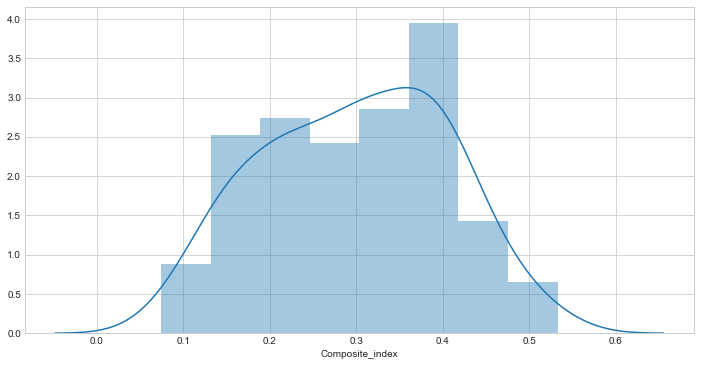

In [40]:
sns.distplot(combined_data_subset['Composite_index'])

Outcome variable _Composite_index_ seems good enough. Now the correlations and multicollinearity as well as VIF can be checked, using the full combined data.

In [41]:
combined_data_subset.corr()

,GDP_per_capita,PPP_conversion_factor,Inflation,Unemployment,Rural_population,Labor_force_participation_rate,Composite_index
GDP_per_capita,1.000000,-0.161471,-0.196181,-0.116402,-0.586754,0.346534,0.576105
PPP_conversion_factor,-0.161471,1.000000,0.176185,-0.082598,0.159567,0.111290,-0.236385
Inflation,-0.196181,0.176185,1.000000,0.030421,0.228833,0.043785,-0.256201
Unemployment,-0.116402,-0.082598,0.030421,1.000000,-0.129352,-0.155563,0.105061
Rural_population,-0.586754,0.159567,0.228833,-0.129352,1.000000,-0.354672,-0.318649
Labor_force_participation_rate,0.346534,0.111290,0.043785,-0.155563,-0.354672,1.000000,0.166852
Composite_index,0.576105,-0.236385,-0.256201,0.105061,-0.318649,0.166852,1.000000


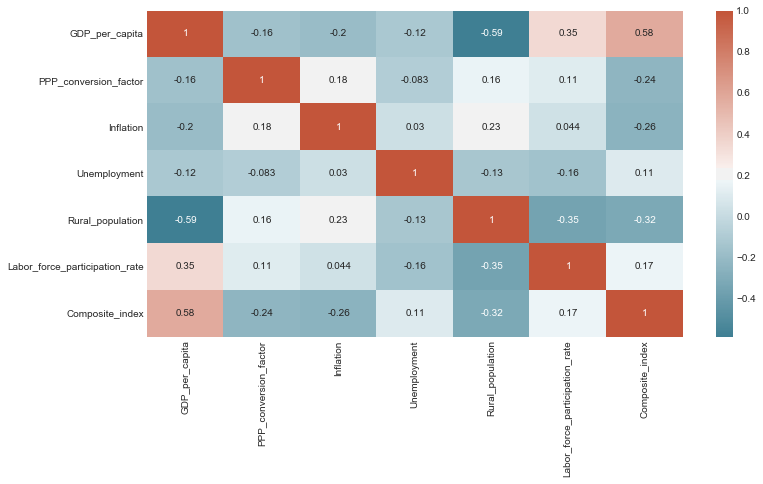

In [48]:
# calculate correlation matrix
corr = combined_data_subset.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

At first glance, it seems like there is no big problem. Let us also check the VIF:

In [30]:
%%capture
#gather features
features = "+".join(combined_data_subset.columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('Composite_index ~' + features, combined_data_subset, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [31]:
vif.round(1)

,VIF Factor,features
0,78.6,Intercept
1,2.3,GDP_per_capita
2,1.1,PPP_conversion_factor
3,1.1,Inflation
4,1.2,Unemployment
5,1.8,Rural_population
6,1.3,Labor_force_participation_rate
7,1.7,Composite_index


As it can be seen from VIF table, all of the factors are small enough, which means there is no sign of strong collinearity to affect our model performance.

There is no need to remove any feature because of collinearity in this case. It is finalized that this subset will be used in the models.

Before finishing, to be able to see general picture, create a pairplot showing one-on-one relations of every variable we have, as well as their individual distributions:

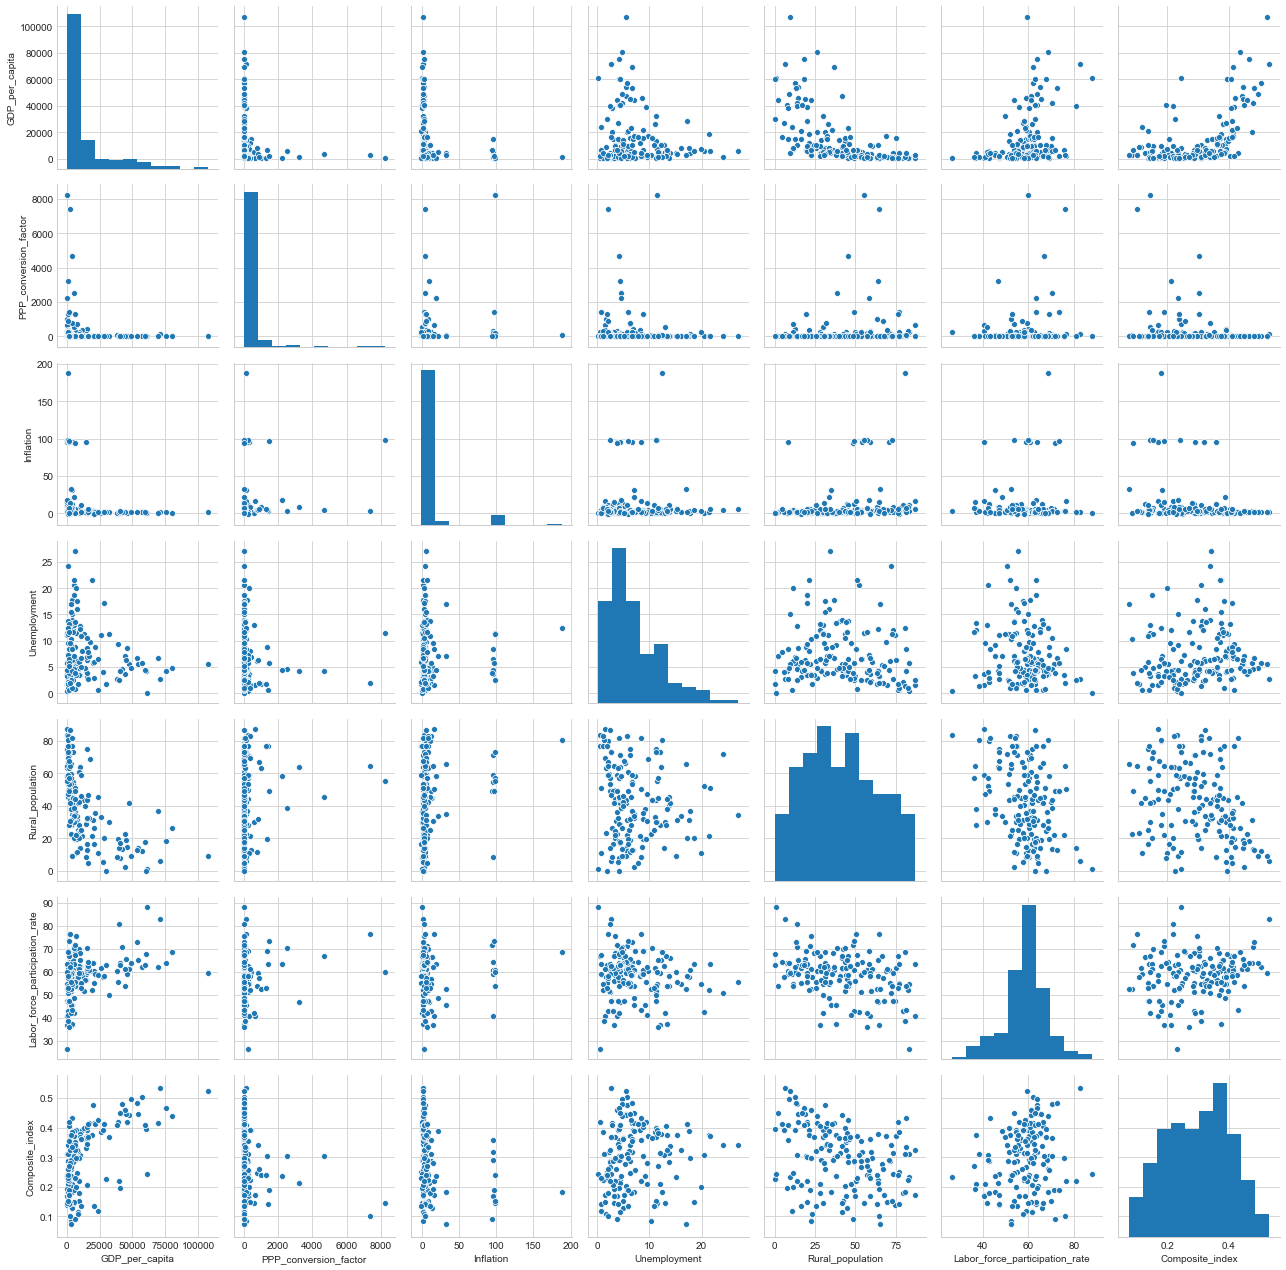

In [51]:
#scatter plots
sns.pairplot(combined_data_subset, height = 2.5)
plt.show()

# Model Building and Selection

Considering the nature of the data and given the outcome variable is numerical, regression models seems suitable. Basically we have the following three algorithms in our disposal for such analysis:

- Linear and Polynomial Regression
- Neural Networks
- Regression Trees and Random Forests

The analysis will start with basic linear regression model and with each iteration more complexity will be added until a satisfactory model is come up with. It is not easy to apply polynomial regression in our case, since it requires deeper understanding of the underlying data and inter-relations, which is beyond the scope of this project.

Regression Tree will also be tried to check in case there is no satisfactory linear model and relationship in the data.

### OLS Linear Regression

In [70]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression() #initiate the model with default parameters
X = combined_data_subset.loc[:,['GDP_per_capita', 'PPP_conversion_factor', 'Inflation', 'Unemployment', 'Rural_population', 'Labor_force_participation_rate']]
y = combined_data_subset.loc[:,'Composite_index'] 
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
# View the coefficients for each feature
pd.Series(lr.coef_, index=X.columns)

GDP_per_capita                    0.000003
PPP_conversion_factor            -0.000013
Inflation                        -0.000634
Unemployment                      0.004072
Rural_population                  0.000657
Labor_force_participation_rate    0.000632
dtype: float64

In [72]:
# The coefficient of determination R^2 of the prediction (training set)
lr.score(X,y)

0.4066608425397289

To check model performance let's apply cross-validation. 5-fold cross-validation is used. For evaluation, Both the default scoring from estimator (R^2) and RMSE is used (Note that we expect RMSE to be close to zero and R^2 to be high).

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
sk_r2 = cross_val_score(lr, X, y, cv=5)
sk_rmse = cross_val_score(lr, X, y, cv=5, scoring = make_scorer(mean_squared_error,greater_is_better=False))
print("Mean score (LR): {:.2f}".format(np.mean(sk_r2)))
print("Mean RMSE score (LR): {:.2f}".format(np.mean(np.sqrt(np.abs(sk_rmse)))))

Mean score (LR): 0.30
Mean RMSE score (LR): 0.09


#### Hyptohesis Testing
Apart from our journet to find a feasible model, let's pause here a bit to check the __statistical significance__ of our regression, whether to see if it is enough to reject or not the null hypothesis provided in the introduction:

In [75]:
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
predictions = model.predict(X_sm) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:        Composite_index   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     17.36
Date:                Sun, 31 May 2020   Prob (F-statistic):           3.04e-15
Time:                        17:58:44   Log-Likelihood:                 172.59
No. Observations:                 159   AIC:                            -331.2
Df Residuals:                     152   BIC:                            -309.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

All from above we can say: _Unemployment_, _Inflation_ and _GDP per capita_ __significantly__ affects _Composite Index_ on their own at 95% confidence level with _Inflation_ is a bit lesser significant determinant. The other variables fails to give significant relevance with high p-values, way above our confidence interval of 95%, majority even at 90%. Good approach would be step-wise feature elimination, starting from high p-value ones, to see if any substantial changes happen in the regression.

The probability of F-statistic on this regression is smaller than critical value of 0.05 by a large margin, therefore we __reject the null hypothesis__ and we conclude that statistically at least some of the regression parameters are nonzero and that the regression equation does have some validity in fitting the data, hinting that indeed a relationship might be there statistically.
***
__Back to model building__, since one of the aims of the project was building a feasible ML model. The OLS model give non-satisfactory R^2 scores so we keep trying to increase score with changing regression model and parameters. If it still fails, we will try decision trees.

### Ridge Linear Regression

In [76]:
from sklearn.linear_model import Ridge
# Use 'lsrq', regularized least squares iterative estimator, with other parameters as default
r = Ridge(solver='lsqr') 
r.fit(X,y)
r.score(X,y)

0.3530242706101425

In [77]:
r.get_params

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)>

LSQR solver shows worse model fit for the training set than OLS. Since LSQR uses an iterative method to approximate the solution. The number of iterations required to reach a certain accuracy depends strongly on the scaling of the problem. 

We need to scale features to improve model accuracy

In [78]:
from sklearn.preprocessing import StandardScaler
# Zero-mean, unit variance normalization is used
std_scaler = StandardScaler() 
X_scaled = std_scaler.fit_transform(X)

In [79]:
r.fit(X_scaled,y)
r.score(X_scaled,y)

0.4066234748600989

With rescaling of all the features it is achieved better fit for the model on training data. Let's check model performance using validation sets via cross-validation, just like we did on OLS:

In [80]:
sk_r_r2 = cross_val_score(r, X_scaled, y, cv=5)
sk_r_rmse = cross_val_score(r, X_scaled, y, cv=5, scoring = make_scorer(mean_squared_error,greater_is_better=False))
print("Mean score (Ridge, lsqr, alpha=1): {:.2f}".format(np.mean(sk_r_r2)))
print("Mean RMSE score (Ridge, lsqr, alpha=1): {:.2f}".format(np.mean(np.sqrt(np.abs(sk_r_rmse)))))

Mean score (Ridge, lsqr, alpha=1): 0.30
Mean RMSE score (Ridge, lsqr, alpha=1): 0.09


Model performance is the same for the Ridge regression with lsqr solver as for the OLS regression, which is confirmed by our scoring metrics - R^2 and RMSE.

However, we can explore how model performance changes as we tune the regularization parameter for the Ridge regression. For that purpose we use validation curves.

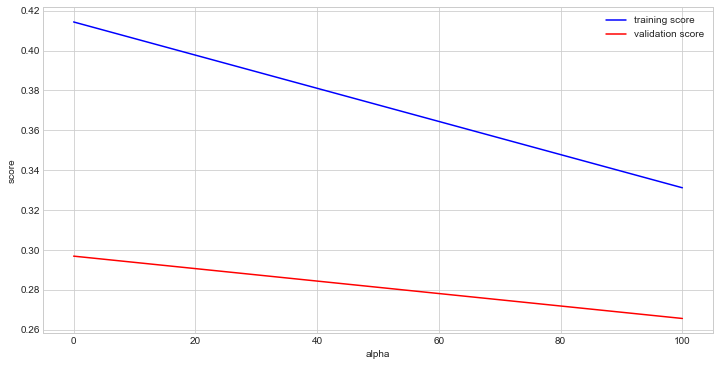

In [83]:
from sklearn.model_selection import validation_curve
alpha_vals = np.logspace(-7, 2, 3)
train_scores, valid_scores = validation_curve(r, X_scaled, y,"alpha",alpha_vals,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.plot(alpha_vals, train_scores_mean, color='blue', label='training score')
plt.plot(alpha_vals, valid_scores_mean, color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('score');

As we increase penalty on coefficients magnitude (alpha >>) coefficients tend to zero, both training set performance and validation score decreases.

__As a result__, by tuning the regularization parameter we didn't achieved an improvement to our model performance (on average) in comparison to the Ridge regression with alpha=1 and lsqr solver, and to Linear Regression with default parameters.

### Polynomials

Further we may explore if adding polynomials of higher degrees to the model increases model performance.

In [92]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

In [93]:
lr.fit(X_poly,y)
sk_p_r2 = cross_val_score(lr, X_poly, y, cv=5)
sk_p_rmse = cross_val_score(lr, X_poly, y, cv=5, scoring = make_scorer(mean_squared_error,greater_is_better=False))
print("Mean score (LR, poly): {:.2f}".format(np.mean(sk_p_r2)))
print("Mean RMSE score (LR, poly): {:.2f}".format(np.mean(np.sqrt(np.abs(sk_p_rmse)))))

Mean score (LR, poly): -338.48
Mean RMSE score (LR, poly): 1.13


It seems like using polynomials makes the model behave a lot worse, with negative r2 scores with huge absolute values. So we omit this model.

### LASSO Regression
In the statistical summary view of OLS, we saw that there were features with no significant contribution (high p-values) on the outcome variable.

We can apply LASSO regression to get rid of features that do not contribute to the explanation of variation in output variable.

In [88]:
from sklearn.linear_model import Lasso
l = Lasso(alpha=0.1)
l.fit(X,y)
l.score(X,y)

0.36741922645412994

In [89]:
# Number of features that LASSO got rid of
np.sum(l.coef_==0)

3

LASSO model fit is worse than the Linear Regression and Ridge regression. It got rid of 3 features out of 6. We can explore how model fit changes with regularization parameter.

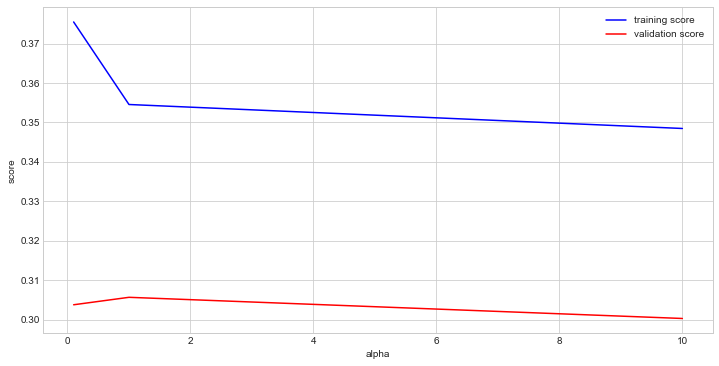

In [90]:
alpha_vals = np.logspace(-1, 1, 3)
train_scores, valid_scores = validation_curve(l, X, y, "alpha", alpha_vals,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.plot(alpha_vals, train_scores_mean, color='blue', label='training score')
plt.plot(alpha_vals, valid_scores_mean, color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('score');

In [91]:
sk_l_r2 = cross_val_score(l, X, y, cv=5)
sk_l_rmse = cross_val_score(l, X, y, cv=5, scoring = make_scorer(mean_squared_error,greater_is_better=False))
print("Mean score (Lasso, alpha=0.1, poly): {:.2f}".format(np.mean(sk_l_r2)))
print("Mean RMSE score (Lasso, alpha=0.1, poly): {:.2f}".format(np.mean(np.sqrt(np.abs(sk_l_rmse)))))

Mean score (Lasso, alpha=0.1, poly): 0.30
Mean RMSE score (Lasso, alpha=0.1, poly): 0.09


As a result all of the linear regressions performed suprisingly similar and a summary can be seen below:

__Models performance comparison on cross-validation sets (R^2 mean score; RMSE mean score):__
- Mean score (LR): 0.30
- Mean RMSE score (LR): 0.09

- Mean score (Ridge, lsqr, alpha=1): 0.30
- Mean RMSE score (Ridge, lsqr, alpha=1): 0.09

- Mean score (Lasso, alpha=0.1, poly): 0.30
- Mean RMSE score (Lasso, alpha=0.1, poly): 0.09

Score of the models seems low, we may choose different imputation strategy, increase sample size, choose another set of features or try different polynomials of higher order.

But here, it is safe to say that, applying linear regression is not a good fit for this relation. As a final analysis, we will pass the Nueral Networks option since it is rather complex process, and we will try regression trees to see if we can come up with better fit or not.

### Regression Tree
Decision Trees are a non-parametric supervised learning method used for regression with DecisionTreeRegressor.

The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

The algorithm is popular when the decision boundary is non-linear and complex, which we weakly concluded from the above low-performing linear models.

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X, y, random_state=0)
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: -0.221


The training set accuracy is 100%, because the tree is large and memorized all the labels on the training data. The test set accuracy worst compared to the linear models we used to fit the same dataset.

There is a critical issue of overfitting here. To decrease model overfitting we experiment on the max depth for the tree. It will allow to provide given number of tests and then stops tree from growing. At last, we expect similar accuracies on training and test sets.

In [106]:
tree = DecisionTreeRegressor(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set (4 levels): {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set (4 levels): {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set (4 levels): 0.702
Accuracy on test set (4 levels): 0.152


In [107]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set (3 levels): {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set (3 levels): {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set (3 levels): 0.581
Accuracy on test set (3 levels): 0.361


In [108]:
tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set (2 levels): {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set (2 levels): {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set (2 levels): 0.433
Accuracy on test set (2 levels): 0.453


With 2 depth levels, we achieved accuracy of around 0.44 which is still not very good, but it is an increase from what we came up with linear models. This further strengtens the idea of underlying relation not being linear.

We conclude our analysis here, with mentionaing iteratively more complex models such as RegressionTrees and even Neual Network as possible __future work__, as well as recommending possible overcomes of these __shortcomings__ in our model strategies such as choosing different imputation strategy, increasing sample size, choosing another set of features or try different polynomials of higher order.

# Implications and Conclusion